In [52]:
import torch as torch
from torch import nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import numpy as np

In [3]:
matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=False)

In [4]:
if torch.cuda.is_available():
    cuda_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(cuda_id)
    print(device_name)
    device = "cuda:0"
else:
    device = "cpu"

NVIDIA GeForce RTX 3090


In [5]:
# torch.manual_seed(42)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.network(img)

In [7]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, input):
        return torch.reshape(input, self.shape)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(64, 1024),
            # why NCHW :(
            Reshape((-1, 64, 4, 4)),
            nn.ConvTranspose2d(64, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 3, 5, 1, 2, bias=False),
            nn.Tanh(),
        )

    def forward(self, img):
        return self.network(img)

In [8]:
# return a vector of n samples from N(0,1) distribution
get_normal = lambda n: torch.normal(torch.zeros(n), 1)
normal_vector = get_normal(64)

In [9]:
gen = Generator()
forwarded_random_image = gen.forward(normal_vector)
forwarded_random_image.shape

torch.Size([1, 3, 32, 32])

In [92]:
def scale_and_display(image):
    plt.imshow((image.squeeze().permute(1, 2, 0).squeeze().detach().numpy() + 1) / 2)

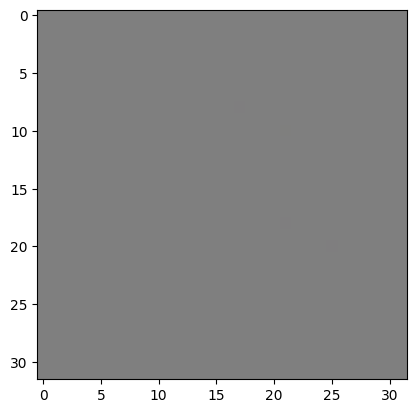

In [93]:
scale_and_display(forwarded_random_image)

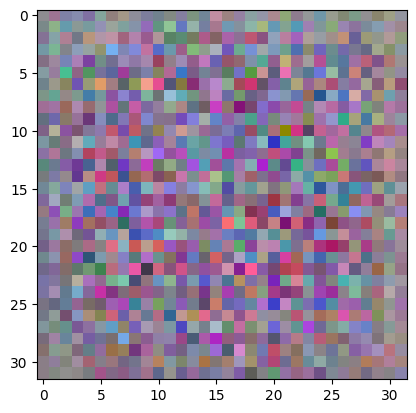

In [94]:
img = forwarded_random_image.permute(0, 2, 3, 1).squeeze().detach().numpy()
maximum = img.max()
minimum = img.min()
scaled_image = (img - minimum) / (maximum - minimum)
plt.imshow(scaled_image)

In [95]:
# Let's ensure that the Discriminator doesn't throw any obvious errors
dis = Discriminator()
dis.forward(forwarded_random_image)

tensor([[0.3894]], grad_fn=<SigmoidBackward0>)

In [96]:
def lambda_scaling(tensor):
    return tensor * 2 - 1

In [97]:
loaded_data = dset.ImageFolder(
    root=".",
    transform=transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Lambda(lambda_scaling),
        ]
    ),
)

In [98]:
data = torch.stack([element[0] for element in loaded_data])
data.shape

torch.Size([975, 3, 32, 32])

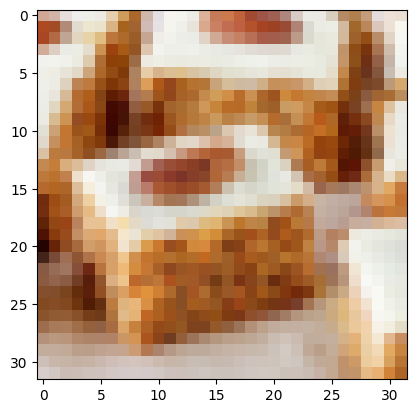

In [101]:
scale_and_display(data[2])

In [100]:
data[0].shape

torch.Size([3, 32, 32])